<a href="https://colab.research.google.com/github/Doppler-67/star-temperature-prediction/blob/main/stars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Цель проекта:**

Нужно построить модель, которая будет определять температуру на поверхностях звезд.

**Описание данных:**

Доступны характеристики звезд и их температура.


⭕ Более подробная информация находится в README файле.

# **Importing libraries**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np
import optuna
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from torchmetrics import MeanSquaredError
from catboost import CatBoostRegressor
from math import ceil

In [2]:
sns.set()

In [3]:
torch.manual_seed(67)
torch.cuda.manual_seed(67)
np.random.seed(67)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# **Data understanding**

In [5]:
data = pd.read_csv('/content/drive/MyDrive/stars_ds_project/stars.csv')

In [6]:
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color\n
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color\n            240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


In [8]:
data.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


# **Data Preparation**

Для начала приведем в порядок названия колонок.

In [9]:
data.columns = ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type', 'star_color']

Проверим на наличие дубликатов.

In [10]:
data.duplicated().sum()

0

Дубликатов нет.

Теперь проверим есть ли пропуски в данных.

In [11]:
data.isna().sum()

temperature           0
luminosity            0
radius                0
absolute_magnitude    0
star_type             0
star_color            0
dtype: int64

Пропусков нет.

# **EDA**

Изучим таргет.

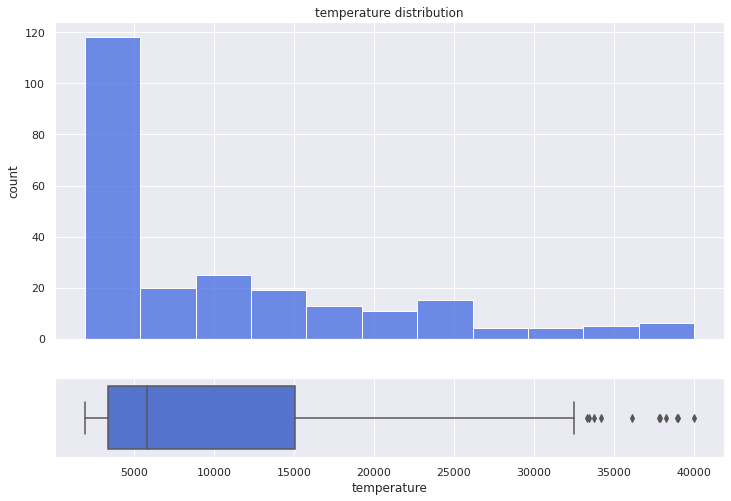

In [12]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['temperature'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data['temperature'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='temperature')
ax_hist.set(ylabel='count')
ax_hist.set(title='temperature distribution')
plt.show()

Таргет распределен экспоненциально.

Изучим колонку luminosity.

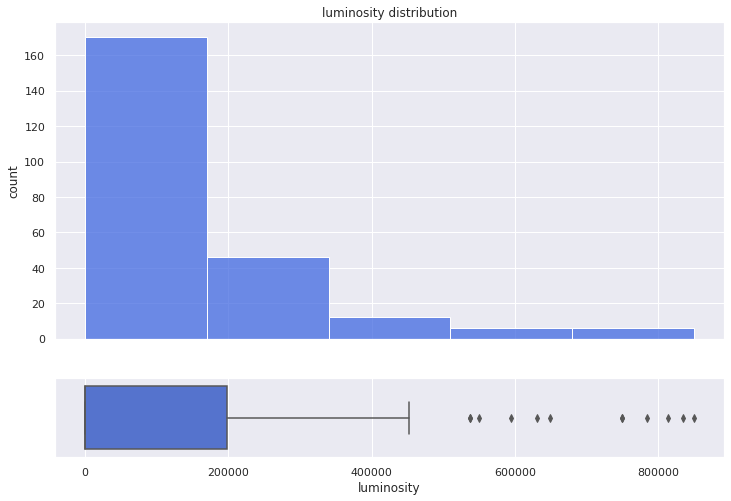

In [13]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['luminosity'], ax=ax_hist, bins=5, color='royalblue')
sns.boxplot(x=data['luminosity'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='luminosity')
ax_hist.set(ylabel='count')
ax_hist.set(title='luminosity distribution')
plt.show()

Колонка luminosuty также распределена экспоненциально.

Изучим колонку radius.

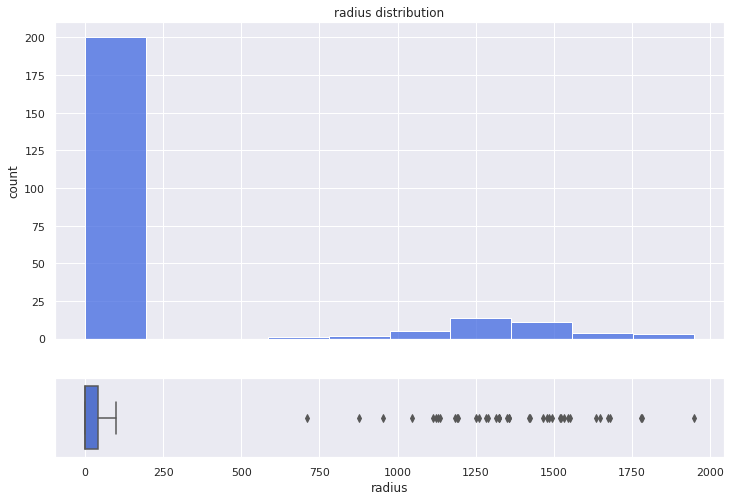

In [14]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['radius'], ax=ax_hist, bins=10, color='royalblue')
sns.boxplot(x=data['radius'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='radius')
ax_hist.set(ylabel='count')
ax_hist.set(title='radius distribution')
plt.show()

Очень много выбросов.

Изучим колонку absolute_magnitude.

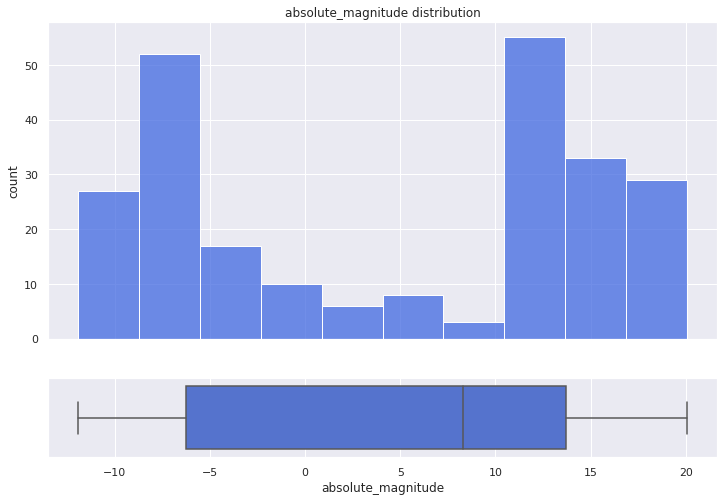

In [15]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['absolute_magnitude'], ax=ax_hist, bins=10, color='royalblue')
sns.boxplot(x=data['absolute_magnitude'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='absolute_magnitude')
ax_hist.set(ylabel='count')
ax_hist.set(title='absolute_magnitude distribution')
plt.show()

Изучим колонку star_type.

In [16]:
data['star_type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64

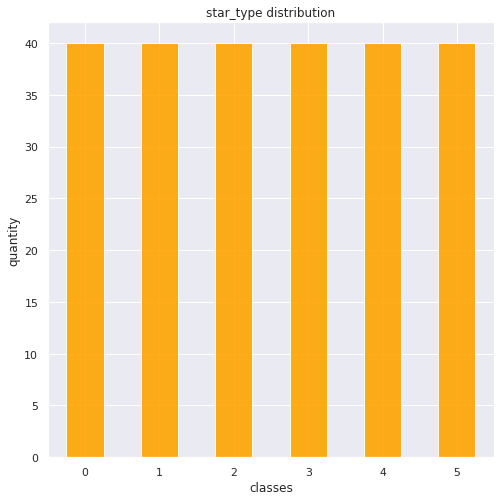

In [17]:
data['star_type'].value_counts().plot(kind='bar', title='star_type distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(8,8))

Изучим колонку star_color.

В колонке star_color много категорий, но много их не из-за разнообразия, а из-за того, что многие цвета одинаковы, но по-разному написаны. Исправим это.

In [18]:
data['star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: star_color, dtype: int64

In [19]:
data['star_color'] = data['star_color'].str.lower()
data['star_color'] = data['star_color'].str.strip()

In [20]:
def filter(x):
    if x == 'blue white':
        return 'blue-white'
    elif x in ['yellowish white','white-yellow']:
        return 'yellow-white'
    elif x == 'whitish':
        return 'white'
    elif x == 'yellowish':
        return 'yellow'
    elif x == 'pale yellow orange':
        return 'pale yellow-orange'
    else:
        return x

In [21]:
data['star_color'] = data['star_color'].apply(filter)

In [22]:
data['star_color'].value_counts()

red                   112
blue                   56
blue-white             41
white                  12
yellow-white           12
yellow                  3
orange                  2
pale yellow-orange      1
orange-red              1
Name: star_color, dtype: int64

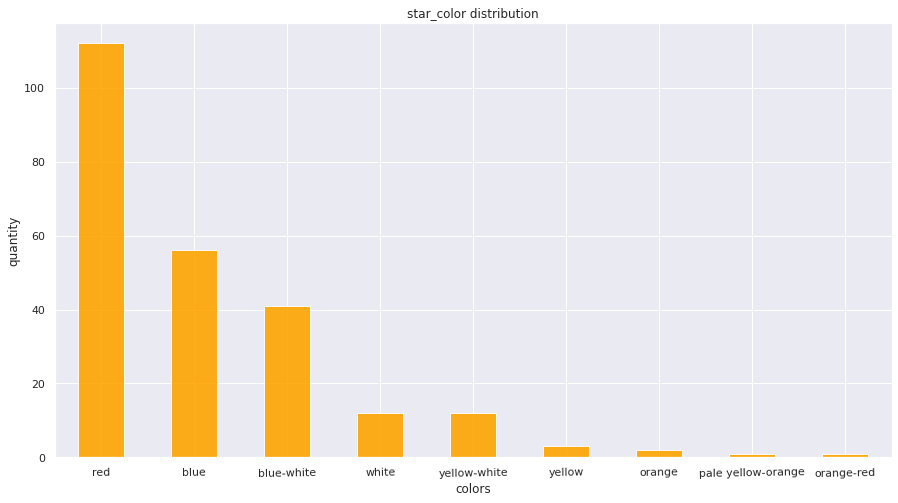

In [23]:
data['star_color'].value_counts().plot(kind='bar', title='star_color distribution', xlabel='colors', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(15,8))

По графику видно, что начиная с желто-белого цвета - цвета представлены в очень маленьком количестве. Поэтому объеденим их всех в отдельную категорию - 'others'.

In [24]:
most_frequent = ['red', 'blue', 'blue-white']
data['star_color'] = data['star_color'].apply(lambda x: 'others' if x not in most_frequent else x)

Изучив количественные колонки видно, что они содержат очень много выбросов. Выбросов настолько много, что, если мы их отбросим, то наш датасет станет на 30% меньше. Наибольшая часть выбросов содержится в колонке radius. Если мы удалим все выбросы (то есть все звезды с большим радиусом) и обучим на этих данных, то при тестировании модели на звездах с большим радиусом - результаты будут плохие, поэтому не будем удалять выбросы.

Попробуем два похода: градиентный бустинг и нейронные сети. Будем использовать catboost и pytorch.

Разделим данные на три части: train, validation, test.

In [25]:
x_train, x_test, y_train, y_test = train_test_split(data.drop('temperature', axis=1), data['temperature'], 
                                                    train_size=0.8, random_state=67, shuffle=True)

In [26]:
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, train_size=0.5, random_state=67, shuffle=True)

Также создадим отдельные данные для catboost.

In [27]:
x_train_cat = x_train
x_valid_cat = x_valid
x_test_cat = x_test

y_train_cat = y_train
y_valid_cat = y_valid
y_test_cat = y_test

Итого у нас 80% данных в train и по 10% в validation и test.

# **Catboost**

In [28]:
machine = "GPU" if torch.cuda.is_available() else "CPU"
machine

'GPU'

In [29]:
enc = OrdinalEncoder()

In [30]:
x_train_cat[['star_type', 'star_color']] = enc.fit_transform(x_train_cat[['star_type', 'star_color']])
x_valid_cat[['star_type', 'star_color']] = enc.transform(x_valid_cat[['star_type', 'star_color']])
x_test_cat[['star_type', 'star_color']] = enc.transform(x_test_cat[['star_type', 'star_color']])

In [31]:
model = CatBoostRegressor(random_seed=67, task_type=machine)

In [32]:
model.fit(x_train_cat, y_train_cat, verbose=0) 

В качестве бейзлайна возьмем catboost со дефолтными параметрами.

In [33]:
y_pred = model.predict(x_valid_cat)
print('base RMSE: ', mean_squared_error(y_valid_cat, y_pred, squared=False))

base RMSE:  5129.657599878146


Теперь подберем оптимальные параметры с помощью optuna.

In [34]:
def objective(trial):

    param = {"depth": trial.suggest_int("depth", 4, 13),
             'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
             'n_estimators': trial.suggest_int('n_estimators', 100, 1000, log=True),
             'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 30)
            } 

    model = CatBoostRegressor(**param, task_type=machine, random_state=67, verbose=0)
    
    model.fit(x_train_cat, y_train_cat, eval_set=[(x_valid_cat, y_valid_cat)])

    rmse = mean_squared_error(y_valid_cat, model.predict(x_valid_cat), squared=False)

    return rmse

In [35]:
study = optuna.create_study(direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=100)

[I 2022-10-26 15:11:15,964] A new study created in memory with name: no-name-5b9e707e-6116-4e13-82d1-fc36978948f4


In [36]:
print('best params:', study.best_params)

best params: {'depth': 10, 'learning_rate': 0.16560513899049317, 'n_estimators': 355, 'l2_leaf_reg': 28}


In [37]:
print('best RMSE: ', study.best_value)

best RMSE:  4031.515365857815


В итоге catboost смог добиться 3820 по метрике RMSE.

Визуализируем гиперпараметры.

In [38]:
optuna.visualization.plot_contour(study)

In [39]:
optuna.visualization.plot_param_importances(study)

Самый влиятельный гиперпараметр - learning_rate.

# **Neural Network**

Подготовим данные к обучению - масштабируем количественные данные и применим технику OHE к категориальным признакам.

In [40]:
x_train = pd.get_dummies(x_train, columns=['star_type', 'star_color'], drop_first=True)
x_valid = pd.get_dummies(x_valid, columns=['star_type', 'star_color'], drop_first=True)
x_test = pd.get_dummies(x_test, columns=['star_type', 'star_color'], drop_first=True)

In [41]:
columns = ['luminosity', 'radius', 'absolute_magnitude']
scaler = StandardScaler()
scaler.fit(x_train[columns])
x_train[columns] = scaler.transform(x_train[columns])
x_valid[columns] = scaler.transform(x_valid[columns])
x_test[columns] = scaler.transform(x_test[columns])

Посмотрим на предобработанные данные.

Для решения данной задачи будет использовать нейросеть.

In [42]:
x_train = torch.FloatTensor(x_train.values).to(device)
x_valid = torch.FloatTensor(x_valid.values).to(device)
x_test = torch.FloatTensor(x_test.values).to(device)

In [43]:
y_train = torch.FloatTensor(y_train.values).reshape(y_train.shape[0], 1).to(device)
y_valid = torch.FloatTensor(y_valid.values).reshape(y_test.shape[0], 1).to(device)
y_test = torch.FloatTensor(y_test.values).reshape(y_test.shape[0], 1).to(device)

In [44]:
n_in_neurons, n_out_neurons = x_train.shape[1], 1 

В качестве метрики возьмем RMSE. А лосс будет MSE.

In [45]:
rmse = MeanSquaredError(squared = False).to(device)
loss = nn.MSELoss()

Для начала попробуем модель с одним скрытым слоем.

Количество эпох для обучения будет 1000.

In [46]:
num_epochs = 1000

Напишем функцию, чтобы не повторять один и тот же код много раз.

In [47]:
def learn_and_eval(model, num_epochs, hidden_layers=1):
  for epoch in range(num_epochs):

        preds = model(x_train) 

        optimizer.zero_grad()
      
        loss_value = loss(preds, y_train)
        loss_value.backward()
            
        optimizer.step()
        
  model.eval()   
  with torch.inference_mode():
    res = rmse(model(x_valid), y_valid)

  if hidden_layers == 1:
    print(f'h1: {n_hidden_neurons_1} | rmse: {res}')
  elif hidden_layers == 2:
    print(f'h1: {n_hidden_neurons_1} | h2: {n_hidden_neurons_2} | rmse: {res}')
  else:
    print(f'h1: {n_hidden_neurons_1} | h2: {n_hidden_neurons_2} | h3: {n_hidden_neurons_3} | rmse: {res}')

In [48]:
h1 = [100, 300, 500, 800, 1000, 1200, 1500, 1800, 2100, 2500]

In [49]:
for n_hidden_neurons_1 in h1:

    model = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_out_neurons)   
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    learn_and_eval(model, num_epochs, hidden_layers=1)

h1: 100 | rmse: 16154.2236328125
h1: 300 | rmse: 15294.2080078125
h1: 500 | rmse: 14527.779296875
h1: 800 | rmse: 13518.240234375
h1: 1000 | rmse: 12945.9423828125
h1: 1200 | rmse: 12428.29296875
h1: 1500 | rmse: 11756.7529296875
h1: 1800 | rmse: 11204.029296875
h1: 2100 | rmse: 10725.4765625
h1: 2500 | rmse: 10256.8671875


Лучший RMSE - 10257, при 2500 нейронах в скрытом слое.

Теперь попробуем модель с двумя скрытыми слоями.

In [50]:
h1 = list(range(300, 1500, 50))
h2 = list(range(300,1200, 50))
samples = 15 # amount of combinations

In [51]:
for i in range(samples):
    
    n_hidden_neurons_1 = h1[np.random.randint(0, len(h1))]
    n_hidden_neurons_2 = h2[np.random.randint(0, len(h2))]
    
    model = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2), 
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)   
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    learn_and_eval(model, num_epochs, hidden_layers=2)

h1: 650 | h2: 900 | rmse: 3420.38232421875
h1: 400 | h2: 1100 | rmse: 3394.694580078125
h1: 900 | h2: 950 | rmse: 3632.841796875
h1: 1450 | h2: 450 | rmse: 3444.820556640625
h1: 550 | h2: 350 | rmse: 3798.45751953125
h1: 600 | h2: 1000 | rmse: 3429.66455078125
h1: 350 | h2: 950 | rmse: 3299.380615234375
h1: 1300 | h2: 550 | rmse: 3452.122314453125
h1: 1100 | h2: 700 | rmse: 3548.453125
h1: 550 | h2: 400 | rmse: 3774.20458984375
h1: 1050 | h2: 900 | rmse: 3646.880859375
h1: 700 | h2: 800 | rmse: 3362.54052734375
h1: 500 | h2: 800 | rmse: 3285.94921875
h1: 950 | h2: 1150 | rmse: 3816.690673828125
h1: 1300 | h2: 700 | rmse: 3655.61962890625


Модель с двумя скрытыми слоями показала себя значительно лучше. Лучший RMSE уменьшился больше, чем в два раза и достиг 3286, при 500 нейронах в первом скрытом слое и 800 нейронах во втором скрытом слое.

Теперь попробуем три скрытых слоя.

In [52]:
h3 = list(range(300, 600, 50))
samples = 15 # amount of combinations

In [53]:
for i in range(samples):
    
    n_hidden_neurons_1 = h1[np.random.randint(0, len(h1))]
    n_hidden_neurons_2 = h2[np.random.randint(0, len(h2))]
    n_hidden_neurons_3 = h3[np.random.randint(0, len(h3))]
    
    model = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Tanh(), 
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2), 
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),   
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons_3, n_out_neurons)    
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    learn_and_eval(model, 1000, hidden_layers=3)

h1: 300 | h2: 350 | h3: 300 | rmse: 5182.4833984375
h1: 900 | h2: 1100 | h3: 300 | rmse: 5470.9638671875
h1: 1000 | h2: 850 | h3: 550 | rmse: 5460.03662109375
h1: 1100 | h2: 500 | h3: 300 | rmse: 5053.19775390625
h1: 1200 | h2: 1150 | h3: 400 | rmse: 5222.3857421875
h1: 900 | h2: 550 | h3: 500 | rmse: 5219.16796875
h1: 350 | h2: 1000 | h3: 400 | rmse: 6023.61767578125
h1: 1400 | h2: 1100 | h3: 450 | rmse: 6193.29541015625
h1: 750 | h2: 750 | h3: 500 | rmse: 5928.18994140625
h1: 500 | h2: 450 | h3: 500 | rmse: 5581.1162109375
h1: 1300 | h2: 1100 | h3: 450 | rmse: 5456.28271484375
h1: 1150 | h2: 550 | h3: 300 | rmse: 4926.5693359375
h1: 1250 | h2: 1000 | h3: 300 | rmse: 5449.1259765625
h1: 350 | h2: 300 | h3: 500 | rmse: 5467.63134765625
h1: 700 | h2: 1100 | h3: 500 | rmse: 6370.603515625


Модель с тремя скрытыми слоями показала себя лучше модели с одним скрытым слоем, но хуже, чем модель с двумя скрытыми слоями. Лучший RMSE - 4927, при 1150 нейронах в первом скрытом слое, 550 нейронах во втором скрытом слое и 300 нейронах в третьем скрытом слое.

Протестировав три различные архитектуры, в качестве основной модели возьмем двух слойную нейронную сеть с 500 нейронами в первом скрытом слое и 800 нейронами во втором скрытом слое.

In [54]:
n_hidden_neurons_1, n_hidden_neurons_2 = 500, 800 

Теперь сделаем так, чтобы наша модель обучалась батчами и подберем оптимальный размер батча.

In [55]:
batch_values = [x_train.shape[0], 60, 50, 40, 30, 25]

In [56]:
for batch_size in batch_values:
        
        model = nn.Sequential(
            nn.Linear(n_in_neurons, n_hidden_neurons_1),
            nn.Tanh(),
            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2), 
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_2, n_out_neurons)   
            ).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        
        num_batches = ceil(len(x_train)/batch_size)
        
        for epoch in range(num_epochs):
    
            order = np.random.permutation(len(x_train))

            for batch_idx in range(num_batches):

                start_index = batch_idx * batch_size
                optimizer.zero_grad()

                batch_indexes = order[start_index:start_index+batch_size]
                x_batch = x_train[batch_indexes]
                y_batch = y_train[batch_indexes]

                preds = model(x_batch) 

                loss_value = loss(preds, y_batch)
                loss_value.backward()

                optimizer.step()
                
        model.eval()
        with torch.inference_mode():
          res = rmse(model(x_valid), y_valid)
        
        print(f'batch_size: {batch_size}, rmse: {res}')

batch_size: 192, rmse: 3280.760498046875
batch_size: 60, rmse: 4585.2265625
batch_size: 50, rmse: 4692.56884765625
batch_size: 40, rmse: 4958.92236328125
batch_size: 30, rmse: 5091.3701171875
batch_size: 25, rmse: 5375.39306640625


В итоге обучение батчами показало себя хуже.

Теперь подберем оптимальное кол-во эпох обучения.

In [57]:
results = np.array([])

In [58]:
model = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2), 
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)   
    ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, 5001):

        optimizer.zero_grad()
      
        preds = model.forward(x_train) 
            
        loss_value = loss(preds, y_train)
        loss_value.backward()
            
        optimizer.step()

        if epoch % 10 == 0:
          res = rmse(model(x_valid), y_valid)
          results = np.append(results, res.cpu().detach().numpy())

In [59]:
epochs = np.arange(1, 5001, 10)

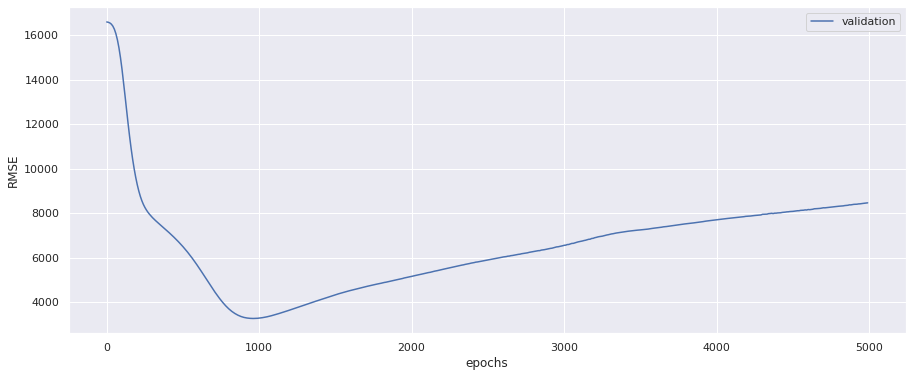

In [60]:
plt.figure(figsize=[15,6])
sns.lineplot(x=epochs, y=results, label='validation')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.show()

Как мы видим, оптимальное кол-во эпох - 1000, потому что дальше уже идет оверфит.

# **Results**

Лучшей моделью оказалсь нейронная сеть, ее и возьмем в качестве основной модели.

|      | catboost | nn |
|------|----------|------|
| RMSE | 3820     | 3286 |

Теперь соединим train и validation, обучим модель и проверим на тестовой выборке.

In [61]:
x_train_and_valid = torch.cat((x_train, x_valid), 0)
y_train_and_valid = torch.cat((y_train, y_valid), 0)

In [62]:
model = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2), 
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)   
    ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):

        optimizer.zero_grad()
      
        preds = model(x_train) 
            
        loss_value = loss(preds, y_train)

        loss_value.backward()
        
        optimizer.step()

model.eval()
with torch.inference_mode():
  predictions = model(x_test)

print('best RMSE:', rmse(predictions, y_test).item())

best RMSE: 2595.615478515625


Теперь визуализируем предсказания модели и реальные значения.

In [63]:
test_preds = pd.DataFrame(predictions.cpu().detach().numpy(), columns=['temperature'])
test_target = pd.DataFrame(y_test.cpu().detach().numpy(), columns=['temperature'])

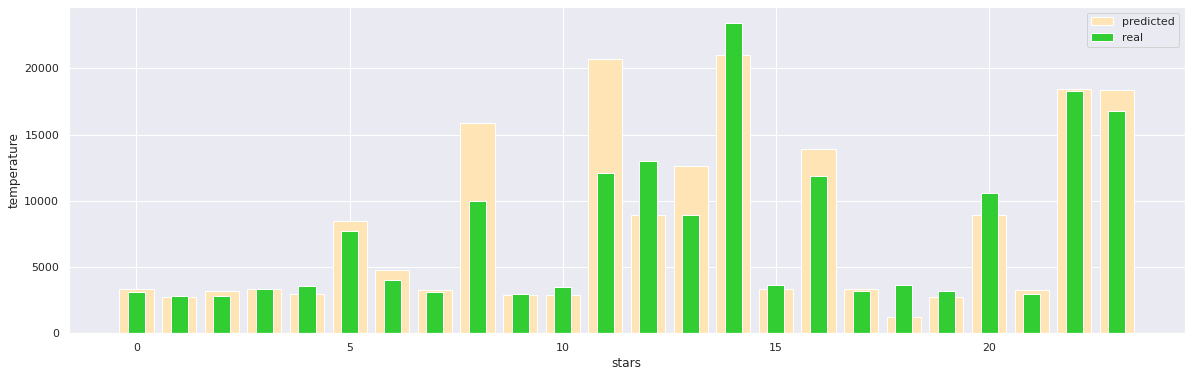

In [64]:
fig, ax = plt.subplots(figsize=[20,6])
plt.bar(x=test_preds.index, height=test_preds['temperature'], color='moccasin' , label='predicted')
plt.bar(x=test_target.index, height=test_target['temperature'], color='limegreen', label='real', width= 0.4)
plt.xlabel('stars')
plt.ylabel('temperature')
ax.legend()
plt.show()

Как мы видим, на маленьких температурах модель практически не ошибается.

# **Conclusion**

**Лучшей всего себя показала нейронная сеть с двумя скрытыми слоями, обученная в 1000 эпох. Удалось достичь 2596 по метрике RMSE. Учитывая, что стандратное отклонение у таргета 9550, то результат у модели отличный.**